Introduction

Pour simplifier les unités de monnaie seront les euros.

#  0 Todo:
* Revoir le plan

In [39]:
# Package pour les expressions régulières
import re

# Package pour la gestion des objets json
import json

# Package manipuler les fichiers et répertoires
import os

# Package pour les tableaux et dataframe
import numpy as np
import pandas as pd
from pandas.errors import MergeError

# Package pour analyse statistique
import scipy.stats as ss
from scipy.stats import loguniform

# Package pour la visualisation graphique
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# Typing des fonctions
from typing import List

# Packages scikit-learn pour modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, LabelEncoder,
    RobustScaler, StandardScaler
)
from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    cross_val_predict, cross_val_score
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import VarianceThreshold, RFECV
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from  xgboost import XGBClassifier
from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve
)
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from shap import (
    TreeExplainer, summary_plot, 
    KernelExplainer,Explainer
)

from sklearn import set_config


In [40]:
pd.options.display.max_columns = None #  pour afficher toutes les colonnes de la base
pd.options.display.max_rows = None  # pour afficher toutes les lignes de la base
pd.set_option('display.max_colwidth', None) # on ne définit pas de largeur max des colonnes afin d'éviter de tronquer leur contenu à l'affichage
set_config(display='diagram') # pour afficher la visualisation graphique des données ou des processus

In [41]:
seed = 42

# 1. Importation et merge des données

In [42]:
#SLOSLO Manque try catch un peu mieux :  raise e
def read_merge_date (url) : 
    found = False
    print(f"Le dossier {url} contient {len(os.listdir(url))} fichiers à fusionner : ")
    print(f"{'-'*80}")
    for file in os.listdir(url):
        if re.search('.csv', file):
            print(f" * {file}")
            df = pd.read_csv(url+file, sep=',')
            print(f"    --> contient {df.shape[0]} lignes et {df.shape[1]} variables.")
            if found == True  :
                merge_on_key = df_.columns.intersection(df.columns)
                try : 
                    df = pd.merge(df_, df, how='outer', on= merge_on_key[0],  validate='one_to_one', sort=False)
                    print("pas de doublons")  # Le fait de faire un merge outer vient aggreger tous les id des clients, s'il y a des doublons au niveau de l'ID alors validate signalera une erreur
                except MergeError as e:
                    print("Erreur pendant la fusion des dataframes, présence de doublons.") 
                    break
            
            df_ = df.copy()
            found = True
    print(f"Le df issu du merging contient {df.shape[0]} lignes et {df.shape[1]} variables.")

    dirup = os.path.dirname(os.path.dirname(os.path.dirname(url)))
    print(dirup)
        
    if not os.path.exists(dirup+'/intermediate/'):
        os.mkdir(dirup+'/intermediate/')
    if not os.path.exists(dirup+'/intermediate/'+url.split("/")[-2]+"/"):
        os.mkdir(dirup+'/intermediate/'+url.split("/")[-2]+"/")

    df.to_csv(dirup+'/intermediate/'+url.split("/")[-2]+'/df_telco.csv', index=False)
    return df
     

### 1.1 Données "Train"

In [43]:
df = read_merge_date("./data/raw/train/")
df.head()

Le dossier ./data/raw/train/ contient 3 fichiers à fusionner : 
--------------------------------------------------------------------------------
 * df_telco_customer_churn_demographics.csv
    --> contient 5158 lignes et 8 variables.
 * df_telco_customer_churn_services.csv
    --> contient 5158 lignes et 28 variables.
pas de doublons
 * df_telco_customer_churn_status.csv
    --> contient 5158 lignes et 2 variables.
pas de doublons
Le df issu du merging contient 5158 lignes et 36 variables.
./data


,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn_value
0,8779-QRDMV,Male,78,No,Yes,No,No,0,No,0,1,None,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,1
1,1658-BYGOY,Male,71,No,Yes,No,Yes,3,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,52,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,1
2,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,14,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,1
3,0390-DCFDQ,Female,76,No,Yes,Yes,Yes,2,Yes,1,1,Offer E,Yes,15.28,No,Yes,Fiber Optic,30,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Mailed Check,70.45,70.45,0.00,0,15.28,85.73,1
4,2656-FMOKZ,Female,70,No,Yes,No,Yes,2,No,0,15,Offer D,Yes,44.07,Yes,Yes,Fiber Optic,19,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Mailed Check,74.45,1145.70,0.00,0,661.05,1806.75,1


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5158 entries, 0 to 5157
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        5158 non-null   object 
 1   gender                             5158 non-null   object 
 2   age                                5158 non-null   int64  
 3   under_30                           5158 non-null   object 
 4   senior_citizen                     5158 non-null   object 
 5   married                            5158 non-null   object 
 6   dependents                         5158 non-null   object 
 7   number_of_dependents               5158 non-null   int64  
 8   referred_a_friend                  5158 non-null   object 
 9   number_of_referrals                5158 non-null   int64  
 10  tenure_in_months                   5158 non-null   int64  
 11  offer                              5158 non-null   objec


### 1.1.1 Description générale

In [45]:
# Affichage des variables qualitatives :
print(f"DataFrame issu de l'importation du fichier /data/raw/train/df_telco.csv : ")
print(f"{'-'*80}")
print(f"Le dataFrame comprend : \n * {df.select_dtypes(exclude = 'object').columns.size} variables qualitatives  : \n{df.select_dtypes(include='object').columns.tolist()}")

# Affichage des variables quantitatives :
print(f" * {df.select_dtypes(include='object').columns.size} variables quantitatives : \n{df.select_dtypes(exclude='object').columns.tolist()}")

DataFrame issu de l'importation du fichier /data/raw/train/df_telco.csv : 
--------------------------------------------------------------------------------
Le dataFrame comprend : 
 * 13 variables qualitatives  : 
['customer_id', 'gender', 'under_30', 'senior_citizen', 'married', 'dependents', 'referred_a_friend', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method']
 * 23 variables quantitatives : 
['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue', 'churn_value']


### 1.1.2 Séparation en données d'entraînement et de test

In [46]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
print(f"Le set de train contient {df_train.shape[0]} observations.")
print(f"Le set de test contient {df_test.shape[0]} observations.")
df_train.to_csv('./data/intermediate/train/df_train.csv', index = False)
df_test.to_csv('./data/intermediate/train/df_test.csv', index = False)

Le set de train contient 4126 observations.
Le set de test contient 1032 observations.


### 1.2 Données "Eval"

In [47]:
df_eval = read_merge_date("./data/raw/eval/")
df_eval.head()

Le dossier ./data/raw/eval/ contient 3 fichiers à fusionner : 
--------------------------------------------------------------------------------
 * eval_df_telco_customer_churn_demographics.csv
    --> contient 1885 lignes et 8 variables.
 * eval_df_telco_customer_churn_status_no_target.csv
    --> contient 1885 lignes et 1 variables.
pas de doublons
 * eval_df_telco_customer_churn_services.csv
    --> contient 1885 lignes et 28 variables.
pas de doublons
Le df issu du merging contient 1885 lignes et 35 variables.
./data


,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.3,0.00,0,390.80,1024.10
1,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,12,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.5,13.43,0,494.00,2995.07
2,4412-YLTKF,Female,72,No,Yes,No,Yes,1,No,0,27,Offer C,Yes,3.33,Yes,Yes,Fiber Optic,18,No,No,Yes,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,78.05,2135.5,0.00,10,89.91,2235.41
3,3445-HXXGF,Male,66,No,Yes,Yes,No,0,Yes,6,58,Offer B,No,0.00,No,Yes,DSL,24,No,Yes,Yes,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,45.30,2651.2,40.95,0,0.00,2610.25
4,0094-OIFMO,Female,78,No,Yes,No,Yes,1,No,0,11,Offer D,Yes,11.59,No,Yes,Fiber Optic,29,No,Yes,No,No,Yes,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,95.00,1120.3,0.00,120,127.49,1367.79


# 2. Analyse de la base de données

import json avec cat_cols et num_cols et all cols

In [48]:
# #SLOSLO changer ici
# cat_cols = df.select_dtypes(include=object).columns.tolist()
# num_cols = df.select_dtypes(exclude=object).columns.tolist()
# all_cols = df.columns.tolist()

In [49]:
with open("variables.json", "r") as read_file:
    json_ = json.load(read_file)


def get_cols_by_type( json_) : 
    bool_ = []
    cat_ = []
    num_ = []
    for key in json_.keys():
        for var in json_[key].keys(): 
            if var == "bool" :
                bool_ += json_[key][var]
            elif var == "cat" :
                cat_ += json_[key][var]
            else :
                num_ += json_[key][var]
    return bool_, cat_, num_

In [50]:
bool_cols, cat_cols, num_cols = get_cols_by_type( json_)
all_cols = bool_cols + cat_cols + num_cols

## 2.1 Analyse de la variable cible

In [51]:
df_train["churn_value"].value_counts(normalize=True)*100

0    73.606398
1    26.393602
Name: churn_value, dtype: float64

25.9 % de clients de la base de données de train ont resilier leur contact avec l'entreprise de télécom au cours de l'années fiscale en cours. La variable cible est déséquilibrée mais représente néanmoins en valeur absolue et relative une représentation suffisante pour ne pas avoir besoind e faire de l'versampling et de 'undersampling.

Nous allons utiliser cette variable cible pour déterminer quelles categories de variables sont importantes pour le churn.

## 2.2 Analyse des variables qualitatives

In [52]:
def get_cols_missing_values ( df_ , cols_ , text_ ) : 
    counter = 0

    # Nous itérons sur toutes les variables quantitatives :
    for var in cols_ :
        # Si une colonne présente des valeurs manquantes:
        #  - on affiche son nom et le nombre de valeurs manquantes
        #  - on incrémente le compteur
        if (df_[var].isna().sum() > 0) :
            print(f"{var} : {df_[var].isna().sum()} manquantes.")
            counter += 1

    print(f"{counter} variables {text_} présentent des valeurs manquantes.")

### 2.2.1 Valeurs manquantes

In [53]:
get_cols_missing_values ( df_train , cat_cols + bool_cols , "qualitatives" ) 

0 variables qualitatives présentent des valeurs manquantes.


### 2.2.2 Statistiques univariées

In [54]:
for key in json_.keys():
    print(f"\n{key.title()}\n{'-' * 15}")
    for var in json_[key]["cat"] + json_[key]["bool"]: 
        print(var)
        if var != "customer_id" :
            print(np.round(df_train[var].value_counts(normalize=True)*100),2)
            print("\n")


Social
---------------
gender
Male      51.0
Female    49.0
Name: gender, dtype: float64 2


under_30
No     80.0
Yes    20.0
Name: under_30, dtype: float64 2


senior_citizen
No     84.0
Yes    16.0
Name: senior_citizen, dtype: float64 2


married
No     52.0
Yes    48.0
Name: married, dtype: float64 2


dependents
No     77.0
Yes    23.0
Name: dependents, dtype: float64 2



Contract&Billing
---------------
contract
Month-to-Month    52.0
Two Year          26.0
One Year          22.0
Name: contract, dtype: float64 2


offer
None       55.0
Offer E    11.0
Offer B    11.0
Offer D     9.0
Offer A     7.0
Offer C     6.0
Name: offer, dtype: float64 2


payment_method
Bank Withdrawal    56.0
Credit Card        39.0
Mailed Check        6.0
Name: payment_method, dtype: float64 2


paperless_billing
Yes    59.0
No     41.0
Name: paperless_billing, dtype: float64 2



Additional Services
---------------
internet_type
Fiber Optic    44.0
DSL            23.0
None           21.0
Cable         

## 2.3 Analyse des variables quantitatives

### 2.3.1 Valeurs manquantes

In [55]:
get_cols_missing_values ( df_train , num_cols , "quantitatives" ) 

0 variables quantitatives présentent des valeurs manquantes.


### 2.3.2 Statistiques univariées

In [56]:
df_train[num_cols].describe()

,age,number_of_dependents,avg_monthly_long_distance_charges,monthly_charge,total_charges,total_extra_data_charges,total_long_distance_charges,total_refunds,total_revenue,avg_monthly_gb_download,number_of_referrals,tenure_in_months
count,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000
mean,46.299321,0.464857,22.618182,64.853139,2265.867448,6.892874,729.354886,1.980041,3000.135167,20.760058,1.897479,31.937712
std,16.621879,0.957320,15.390541,29.950669,2266.591729,25.159692,833.537327,7.934621,2860.326475,20.594194,2.966383,24.442373
min,19.000000,0.000000,0.000000,18.250000,18.850000,0.000000,0.000000,0.000000,21.360000,0.000000,0.000000,1.000000
25%,32.000000,0.000000,8.972500,36.537500,374.912500,0.000000,66.057500,0.000000,592.862500,4.000000,0.000000,9.000000
50%,46.000000,0.000000,22.300000,70.350000,1376.650000,0.000000,381.945000,0.000000,2046.845000,17.000000,0.000000,28.000000
75%,59.000000,0.000000,36.105000,89.787500,3769.050000,0.000000,1152.590000,0.000000,4754.065000,27.000000,3.000000,54.000000
max,80.000000,9.000000,49.990000,118.750000,8672.450000,150.000000,3564.000000,49.570000,11979.340000,85.000000,11.000000,72.000000


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


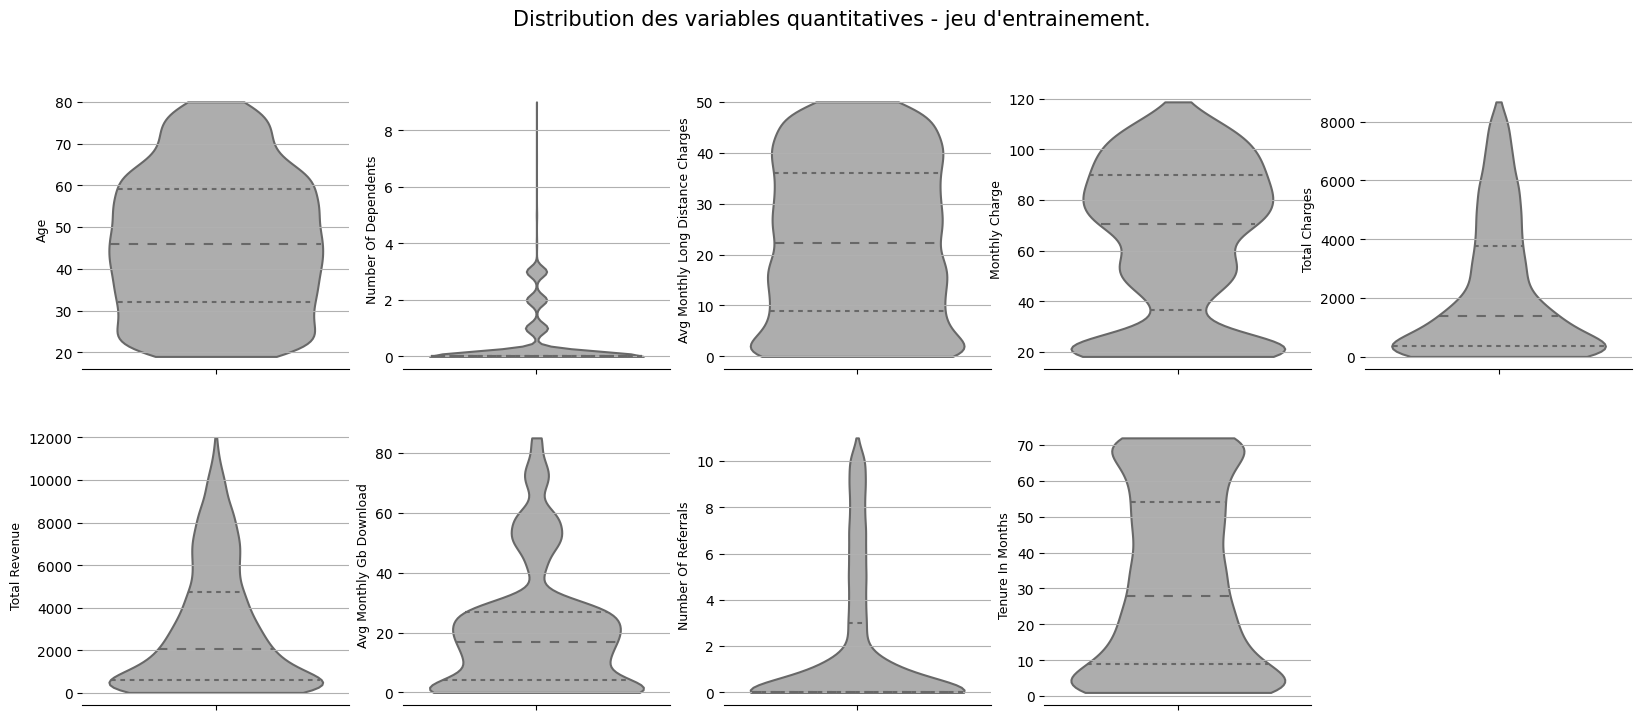

In [57]:
ncols = 5
cols_ = [elt for elt in num_cols if elt not in ["churn_value", "total_refunds", "total_extra_data_charges", "total_long_distance_charges"]]
nrows = (np.ceil(len(cols_)/ncols)).astype(int)
#"monthly_charge", "total_charges", "total_extra_data_charges", "total_long_distance_charges", "total_refunds", 'total_revenue']

fig, axes = plt.subplots(ncols= ncols, nrows = nrows, figsize=( 4*ncols, 4*nrows))
i=0
j = 0

for var in cols_ :
 # Création de la figure
   if j== ncols : 
        j=0
        i+=1

   
   #4. Création du boxplot
   sns.violinplot(ax=axes[i,j], data=df_train, y=var, color='#adadad', inner='quart',  density_norm="count", cut=0)#, flierprops={"marker": ".", "markersize" : "4"})


   #5. Gestion des axis et labels
   axes[i,j].set_xlabel("")
   axes[i,j].set_ylabel(var.replace("_", " ").title(), fontsize=9)

   #6. Ajout des lignes horizontales
   axes[i,j].grid(visible=True, which='major', axis='y')
   axes[i,j].spines['top'].set_visible(False)
   axes[i,j].spines['right'].set_visible(False)
   axes[i,j].spines['bottom'].set_visible(True)
   axes[i,j].spines['left'].set_visible(False)
   j+=1

if j<5 :
    axes[i,j].set_axis_off()

fig.suptitle(f'Distribution des variables quantitatives - jeu d\'entrainement.',fontsize=15)
fig.show()

Globalement les variables quantitatives ne semblent pas présenter d'outliers.
Les clients répertoriés présentent les catérisitques suivantes:
* un age médian de 46 et un nombre de personnes à charge < 1
* ils sont clients depuis en moyenne moins de 3 ans avec un prélèvement mensuel de leurs abonnement de 70 euros. 
* Ils ont prrainné en moyenne 2
* et ont téléchargent une mediane de 17 GB


## 2.4 Cohérence entre variables

In [58]:
df_train_c = df_train.copy()

### 2.4.1 Variables à caractère social

Additional checks :
** if age >= 65 --> senior_citizen = yes
** if age <= 30 --> under_30 = yes
** if referred_a_friend --> number_of_referrals > 0
** check si le conjoint fait parti des dépendants
** check si dependents = yes number_of_dependants > 0

In [59]:
#** if age >= 65 senior_citizen
((df_train_c["age"]>= 65) & (df_train_c["senior_citizen"]=="No")).sum()


0

In [60]:
#** if age <= 30 under_30
((df_train_c["age"]< 30) & (df_train_c["under_30"]=="No")).sum()

0

In [61]:
# if referred_a_friend --> number_of_referrals > 0
((df_train_c["referred_a_friend"]== "yes") & (df_train_c["number_of_referrals"]<1)).sum()

mask = df_train_c["referred_a_friend"]== "No"
df_train_c[mask]["number_of_referrals"].describe()

count    2258.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: number_of_referrals, dtype: float64

In [62]:
# check if le conjoint fait parti des dépendants
mask = df_train_c["married"] =="Yes"
df_train_c[mask]["number_of_dependents"].describe()


count    1968.000000
mean        0.784553
std         1.130222
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         9.000000
Name: number_of_dependents, dtype: float64

In [63]:
mask = (df_train_c["married"] =="Yes") & (df_train_c["number_of_dependents"]<1)
mask.sum()
## cl :le conjoint ne fait ps parti des dépendants

1201

In [64]:
#check si dependents = yes number_of_dependants > 0
mask = (df_train_c["dependents"] == "Yes") & (df_train_c["number_of_dependents"]<1)
mask.sum()

0

### 2.4.2 Variables concernant les services additionnels

In [65]:
# Vefification que si pas d'internet service alors le type internet est Nan
mask = (df_train_c["internet_service"] == "No") & (df_train_c["internet_type"].isna())
mask.sum()

0

In [66]:
mask = (df_train_c["internet_service"] == "Yes") 
print(df_train_c[mask]["internet_type"].value_counts())
print(mask.sum())

## Cl : Ok

Fiber Optic    1801
DSL             967
Cable           480
Name: internet_type, dtype: int64
3248


### 2.4.3 Variables concernant les charges

In [67]:
# Vérification que total_charges / tenure in month = monthly_charge
df_train_c["monthly_charge_slo"] = df_train_c["total_charges"]/df_train_c["tenure_in_months"]
(df_train_c["monthly_charge"]-df_train_c["monthly_charge_slo"]).describe()

count    4126.000000
mean        0.020711
std         2.668964
min       -17.125000
25%        -1.166429
50%         0.000000
75%         1.171745
max        19.125000
dtype: float64

In [68]:
# Vérification que total_charges / tenure in month = monthly_charge
df_train_c["avg_monthly_long_distance_charges_slo"] = df_train_c["total_long_distance_charges"]/df_train_c["tenure_in_months"]
(df_train_c["avg_monthly_long_distance_charges"]-df_train_c["avg_monthly_long_distance_charges_slo"]).describe()

count    4.126000e+03
mean    -4.638935e-17
std      1.900520e-15
min     -7.105427e-15
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.105427e-15
dtype: float64

In [69]:
# Vérification que total_charges / tenure in month = monthly_charge
df_train_c["avg_monthly_long_distance_charges_slo"] = df_train_c["total_long_distance_charges"]/df_train_c["tenure_in_months"]
(df_train_c["avg_monthly_long_distance_charges"]-df_train_c["avg_monthly_long_distance_charges_slo"]).describe()

count    4.126000e+03
mean    -4.638935e-17
std      1.900520e-15
min     -7.105427e-15
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.105427e-15
dtype: float64

In [70]:
df_train_c["total_revenue_check"] = df_train_c.loc[:,"total_charges"]-df_train_c.loc[:,"total_refunds"]+df_train_c.loc[:,"total_extra_data_charges"]+df_train_c.loc[:,"total_long_distance_charges"]
(df_train_c["total_revenue_check"]-df_train_c["total_revenue"]).describe()

count    4.126000e+03
mean     1.693696e-15
std      2.832239e-13
min     -1.818989e-12
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.818989e-12
dtype: float64

CL : le total_revenue = total_charges + total_extra_data_charges + total_long_distance_charges - total_refunds


On regarde le lien entre total_extra_data_charges et unlimited_data
 et

In [71]:

 df_train_c[df_train_c["unlimited_data"] == "Yes"]["total_extra_data_charges"].describe()

count    2774.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: total_extra_data_charges, dtype: float64

 Cl :Il semble que les clients souscrivant un abo cunlimited_data n'ont jamais avant été en dépassement.
Alors qu'il arrive que les autres soient en dépassement.

### 2.4.4 Relation entre les offres et les différents services

On cherche à voir si certain services sont proposées d'office dans les différentes offres

Detail des différentes souscription :
Offre A : 

In [72]:
for offre in df_train_c["offer"].unique() : 
    #Offre A
    mask  = df_train_c["offer"]==offre
    print(f"Il y a {mask.sum()} clients ayant souscrit à {offre}.")

    for var in json_["additional services"]["bool"] : 
        print(df_train_c[mask][var].value_counts())


Il y a 2264 clients ayant souscrit à None.
No     1503
Yes     761
Name: device_protection_plan, dtype: int64
Yes    2043
No      221
Name: phone_service, dtype: int64
No     1389
Yes     875
Name: multiple_lines, dtype: int64
Yes    1778
No      486
Name: internet_service, dtype: int64
No     1652
Yes     612
Name: online_security, dtype: int64
No     1499
Yes     765
Name: online_backup, dtype: int64
No     1612
Yes     652
Name: premium_tech_support, dtype: int64
Yes    1510
No      754
Name: unlimited_data, dtype: int64
Il y a 366 clients ayant souscrit à Offer D.
No     283
Yes     83
Name: device_protection_plan, dtype: int64
Yes    335
No      31
Name: phone_service, dtype: int64
No     242
Yes    124
Name: multiple_lines, dtype: int64
Yes    270
No      96
Name: internet_service, dtype: int64
No     294
Yes     72
Name: online_security, dtype: int64
No     280
Yes     86
Name: online_backup, dtype: int64
No     296
Yes     70
Name: premium_tech_support, dtype: int64
Yes    232


In [73]:
#Offre A
mask  = df_train_c["offer"].isna()
print(f"Il y a {mask.sum()} clients ayant souscrit à {offre}.")

for var in json_["additional services"]["bool"]  : 
    print(df_train_c[mask][var].value_counts())


Il y a 0 clients ayant souscrit à Offer E.
Series([], Name: device_protection_plan, dtype: int64)
Series([], Name: phone_service, dtype: int64)
Series([], Name: multiple_lines, dtype: int64)
Series([], Name: internet_service, dtype: int64)
Series([], Name: online_security, dtype: int64)
Series([], Name: online_backup, dtype: int64)
Series([], Name: premium_tech_support, dtype: int64)
Series([], Name: unlimited_data, dtype: int64)


Cl : Il n'y a pas de pack incluant les différents services supplemntaires dans les différentes offres proposés

## 2.5 Statistiques bivariées avec la variable cible

### 2.5.1 Liaison entre les variables quantitatives et la variable cible

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


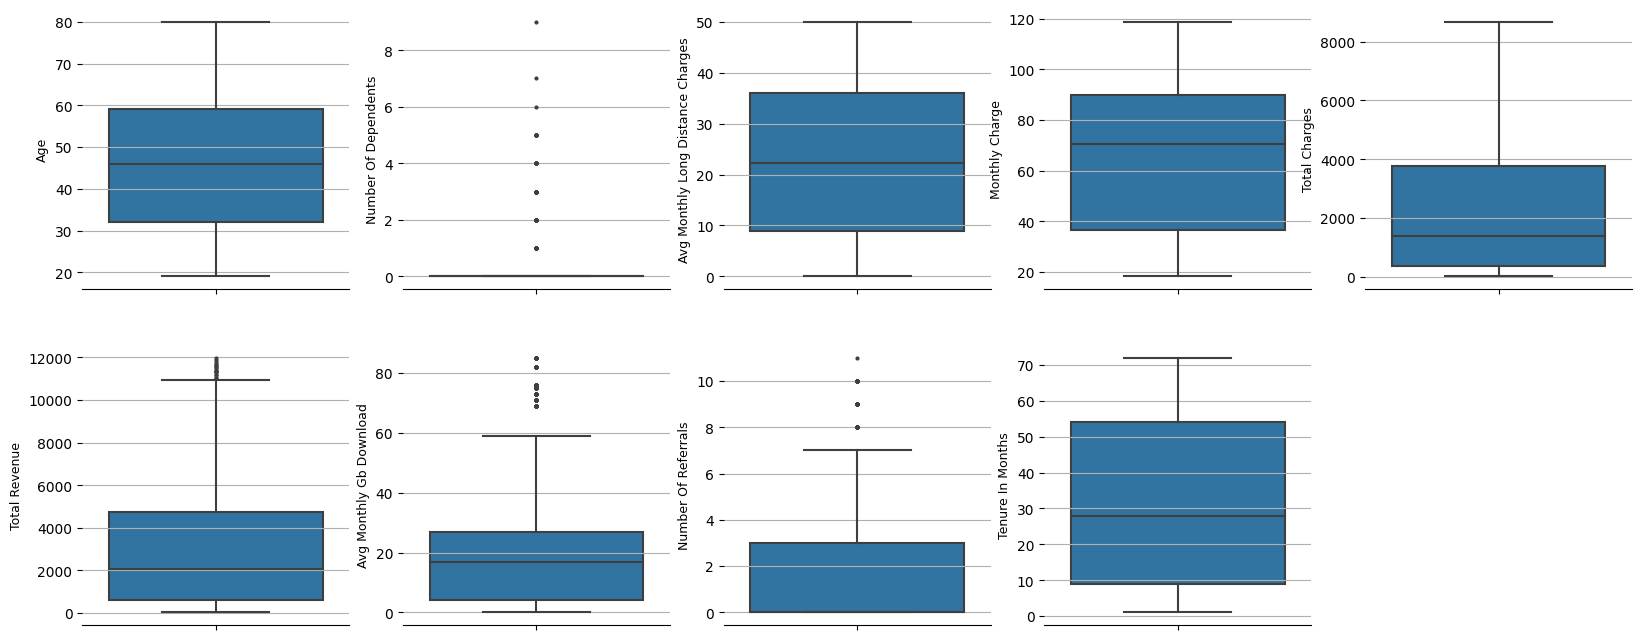

In [74]:
ncols = 5
num_cols_ = [elt for elt in num_cols if elt not in ["churn_value", "total_refunds", "total_extra_data_charges", "total_long_distance_charges"]]
nrows = (np.ceil(len(num_cols_)/ncols)).astype(int)


fig, ax = plt.subplots(ncols= ncols, nrows = nrows, figsize=( 4*ncols, 4*nrows))
i=0
j = 0
for var in num_cols_ :
 # Création de la figure
    if j== ncols :
        i+=1
        j = 0
    #4. Création du boxplot
    sns.boxplot(ax=ax[i,j], data=df_train, y=var, hue="churn_value", width = 0.8, flierprops={"marker": ".", "markersize" : "4"})


    #5. Gestion des axis et labels
    ax[i,j].set_xlabel('')
    ax[i,j].set_ylabel(var.replace("_", " ").title(), fontsize=9)

    #6. Ajout des lignes horizontales
    ax[i,j].grid(visible=True, which='major', axis='y')
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['bottom'].set_visible(True)
    ax[i,j].spines['left'].set_visible(False)

    #7. Définition du titre principal
    #fig.suptitle(f'Titre.')
    j+= 1
if j<5 :
    ax[i,j].set_axis_off()
fig.show()

Il semble que les clients ayant résilier leur contact :
- aient une moyenne d'age plus élévé
- n'aient pas d'enfants àcharge
- aient parrainé moins de personnes
- qu'ils soient abonné depuis moins longtemps
- qu'il paient des charges mensuelles beaucoup plus élévées
En résumé plus la clientèle est fidélisée sur le long terme, et le moins elle paie chère le moins de probabilité elle a de quitter l'entreprise.

Par contre les variables avg_monthly_long_distance_charges et avg_monthly_gb_download ne sont pas importantes dans ce contexte.

Les labels : 
* légende sur le coté
* couleur à changer




### 2.5.2 Liaison entre les variables qualitatives et la variable cible

In [75]:
# ncols = 4
# cat_cols_ = [elt for elt in cat_cols if elt not in ["customer_id", "total_refunds", "total_extra_data_charges", "total_long_distance_charges"]]
# nrows = (np.ceil(len(cat_cols_)/ncols)).astype(int)


# fig, ax = plt.subplots(ncols= ncols, nrows = nrows, figsize=( 4*ncols, 4*nrows))
# # Définition de la palette et de la légende
# palette = ['#226ECC', '#CC226E']
# legend_ = [Patch(color='#226ECC', label="Automatique"),
#            Patch(color='#CC226E', label="Manuelle") ]
# i=0
# j = 0
# for var in cat_cols_ :
#  # Création de la figure
#     if j== ncols :
#         i+=1
#         j = 0
#     #4. Création du boxplot
#     df_plot = (np.round(df_train.value_counts(subset=[var,"churn_value"],normalize=True)*100,1)).reset_index()
#     sns.barplot(ax=ax[i,j], y="proportion", x=var, hue = "churn_value", data= df_plot , palette = palette,  width=0.9, alpha = 1)

# #     # 1. Création du barplot vertical représentant la distribution des véhicules selon leur type de boîte de vitesse et le nombre de rapports
# #     #sns.barplot(ax = ax[i,j], y="proportion", x="Nb_rapports", hue = "Type_Boite_Vitesse", data= df_plot , palette = palette,  width=0.9, alpha = 1)
#     ax[i,j].bar_label(ax[i,j].containers[0], fontsize=8)
#     ax[i,j].bar_label(ax[i,j].containers[1], fontsize=8)

# #     # 2. Définition des axis et labels
#     ax[i,j].set_xlabel(var, fontsize=8)
#     ax[i,j].set_ylabel("Poucentage (%)", fontsize=8)

# #     # 3. Ajout des lignes horizontales
#     ax[i,j].grid(visible=True, which="major", axis='y')
#     ax[i,j].spines['top'].set_visible(False)
#     ax[i,j].spines['left'].set_visible(False)
#     ax[i,j].spines['right'].set_visible(False)

# #     # 4. Gestion de la légende et du titre principal
#     #ax[i,j].legend( handles = legend_, loc='center left', bbox_to_anchor= (1.04, 0.5), ncol=1,
# #             borderaxespad=0, frameon=False, title = "Type de boîte de vitesses :", fontsize=9)
# #    ax[i,j].set_title("Distribution des véhicules en fonction du nombre de rapports \net du type de boîte de vitesses.",loc= 'left', fontsize=10)
#     j+=1



# # fig.show()

Séparer en grandes catégories pour que cela soit lisible:
regarder différence entre corsstab et value_counts 
et voir comment analyser au regard de la target cible

legende : 1 fois à droite
changer les couleur
les lgendes : majus + _
Pourcentage : juste une fois

Text(0.5, 0.98, 'Distribution des véhicules en fonction du nombre de rapports \net du type de boîte de vitesses.')

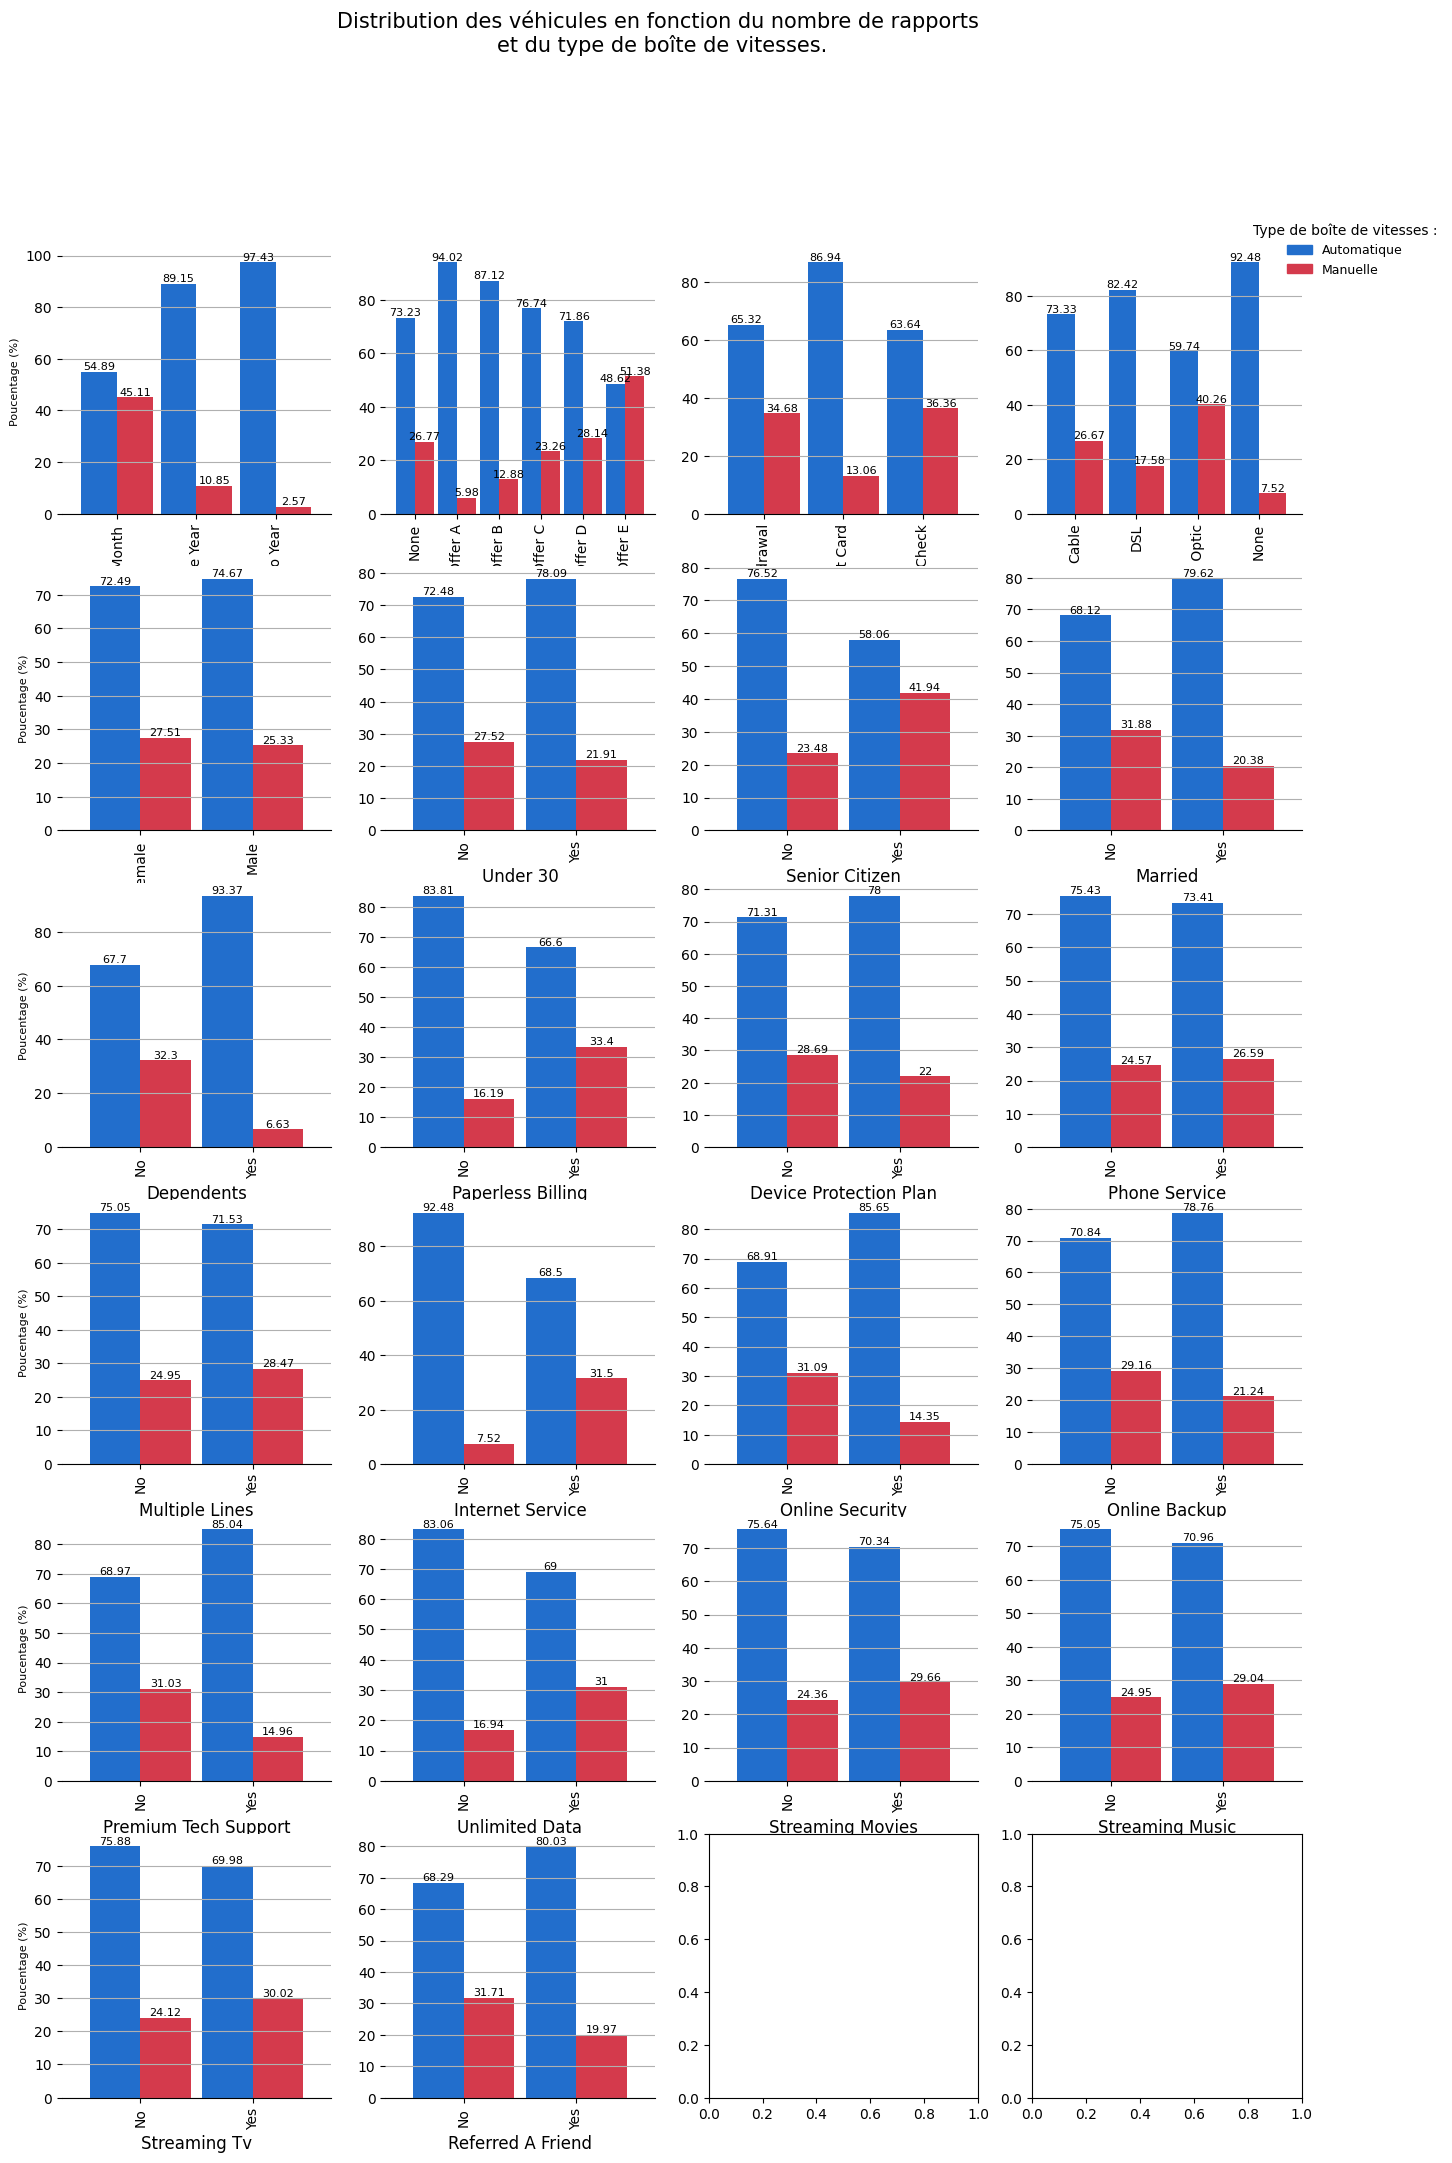

In [76]:
ncols = 4
cat_cols_ = cat_cols+bool_cols #[elt for elt in cat_cols+bool_cols if elt not in ["customer_id", "total_refunds", "total_extra_data_charges", "total_long_distance_charges"]]
nrows = (np.ceil(len(cat_cols_)/ncols)).astype(int)


fig, ax = plt.subplots(ncols= ncols, nrows = nrows, figsize=( 4*ncols, 4*nrows))
# Définition de la palette et de la légende
palette = ['#226ECC', '#D43A4C']
legend_ = [Patch(color='#226ECC', label="Automatique"),
           Patch(color='#D43A4C', label="Manuelle") ]
i=0
j = 0
for var in cat_cols_ :
 # Création de la figure
    if j== ncols :
        i+=1
        j = 0
    #4. Création du boxplot
    df_plot = np.round((pd.crosstab(index=df_train[var], columns=df_train["churn_value"], normalize="index")*100),2)
    df_plot.plot(ax = ax[i,j],kind='bar',color= palette,  width=0.9, alpha = 1, legend = False)

#     # 1. Création du barplot vertical représentant la distribution des véhicules selon leur type de boîte de vitesse et le nombre de rapports
#     #sns.barplot(ax = ax[i,j], y="proportion", x="Nb_rapports", hue = "Type_Boite_Vitesse", data= df_plot , palette = palette,  width=0.9, alpha = 1)
    ax[i,j].bar_label(ax[i,j].containers[0], fontsize=8)
    plt.xticks(rotation=0)
    ax[i,j].bar_label(ax[i,j].containers[1], fontsize=8)

#     # 2. Définition des axis et labels
    ax[i,j].set_xlabel(var.replace("_", " ").title(), fontsize=12)
    ax[i,j].set_ylabel("")
    if j==0 : 
        ax[i,j].set_ylabel("Poucentage (%)", fontsize=8)

#     # 3. Ajout des lignes horizontales
    ax[i,j].grid(visible=True, which="major", axis='y')
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['left'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)

#     # 4. Gestion de la légende et du titre principal
    j+=1


ax[i,j].legend( handles = legend_, loc='center left', bbox_to_anchor= (2, nrows+1), ncol=1,
            borderaxespad=0, frameon=False, title = "Type de boîte de vitesses :", fontsize=9)
fig.suptitle("Distribution des véhicules en fonction du nombre de rapports \net du type de boîte de vitesses.",fontsize=15)
    
# fig.show()

En comparant les différents taux en fonction du taux de cible étant de 25.9 %, on oeut déjà dégager quelques tendances, il semble que les clients ayant quitter l'entreprise de télécom soient :
* plutôt de sénior (age > 65) non marié et sans enfant à charge.
* Ceux-ci ont souscrit aux offres D/E, à un service Internet (Fibre Optique), à un forfait data illimité
* Ils ont tendance à streamer à la fois tv, musique
* Leur abonnement a un engagement mensuel et ils n'ont pas parrainé d'amis.

Note: Rajouter la limiter 25.9 sur les graphes

In [77]:
# Change le json et les cat_cols selon


def upd_json(json_, var) : 
    for var1 in var : 
        found = False
        for key in json_.keys() : 
            if not(found) : 
                for key_1 in json_[key]:
                    if var1 in json_[key][key_1] :
                        json_[key][key_1].remove(var1)
                        found = True
                        break
            else :
                break
    return json_

In [78]:
# colonnes à supprimer
col_to_dels = ["number_of_dependents","total_charges","total_long_distance_charges","total_revenue"]
json_ = upd_json(json_, col_to_dels)

# 3. Preprocessing des données

## 3.1 Suppression des variables à faible variance / constante

Parmi les variables catégorielles, celle-ci ne présentent pas de contante.
Regardons à présent si les variables numériques comptent parmi elle des varaibles à faible variance

In [79]:
select_var = VarianceThreshold(threshold = 0.3)
num_col_var = select_var.fit(df_train[num_cols]).get_feature_names_out()

Pas de variable à faible variance

## 3.2 Discretisation des variables numériques

In [80]:
def discretization_variables (df : pd.DataFrame, var, bins : List, cols_) -> pd.DataFrame : 
    bins_ = [df[var].min()] + bins + [df[var].max()]
    print(bins_)
    df[var + "_bins"]=pd.cut(x = df[var],include_lowest = True,
                        bins = bins_, labels=False)
    cols_.append(var + "_bins")
    return df, cols_
## SLO à tester

In [81]:
def plot_discretized_variable (df : pd.DataFrame, var, bin :List) :
    fig, ax = plt.subplots(figsize=(10,6))
    bins_ = [df[var].min()] + bin + [df[var].max()]
    print(bins_)
    sns.histplot(ax = ax, data=df, x=var, bins=bins_)
    ax2 = ax.twinx()
    sns.kdeplot(ax = ax2,data = df, x=var,  alpha=0.6, fill=True,  legend=False)
    plt.title('Histogramme de la variable continue')
    plt.xlabel('Variable continue')
    plt.ylabel('Fréquence')
    plt.show()

## à Tester

In [82]:
cat_num_cols = []

### 4.2.1 Age

[19, 30, 40, 50, 65, 80]


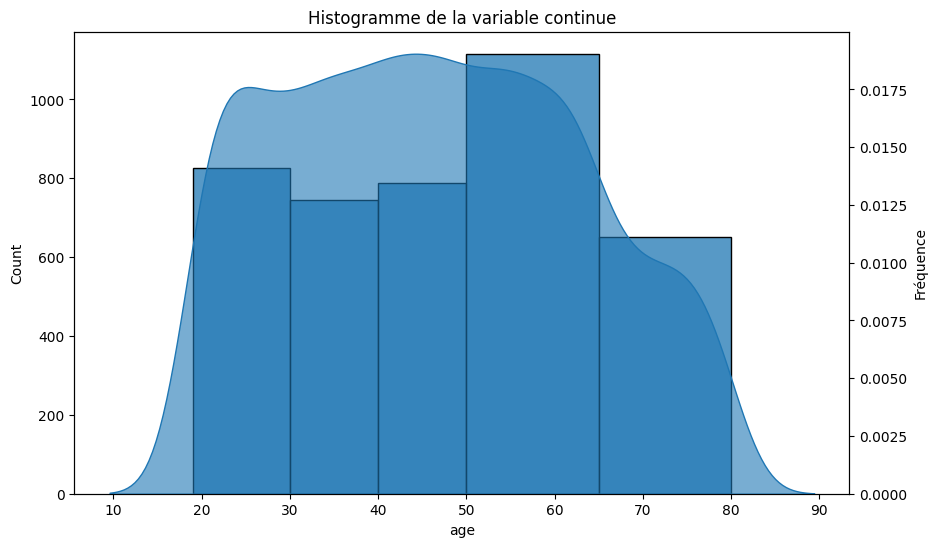

In [83]:
plot_discretized_variable (df_train, 'age', [30,40,50,65]) 

In [84]:
df_train,cat_num_cols = discretization_variables (df_train, 'age', [30,40,50,65], cat_num_cols)  
df_train.head()
json_["social"]["cat"].append("age_bins")



[19, 30, 40, 50, 65, 80]


# Faire sauter senior_citizen

### 4.2.2 Taille de la famille

# Faire sauter dépendants

In [85]:
df_train["family_size"] = df_train["number_of_dependents"] + 1 + df_train["married"].map({"Yes" : 1, "No": 0})
df_train[["family_size","number_of_dependents","married"]].sample(n=5)

,family_size,number_of_dependents,married
695,3,1,Yes
1940,2,0,Yes
58,1,0,No
2850,2,0,Yes
2053,1,0,No


A noter que les offres en téléphonies sont souvent pour des familles de :
1, 2, 4, >4

[1, 2, 4, 11]


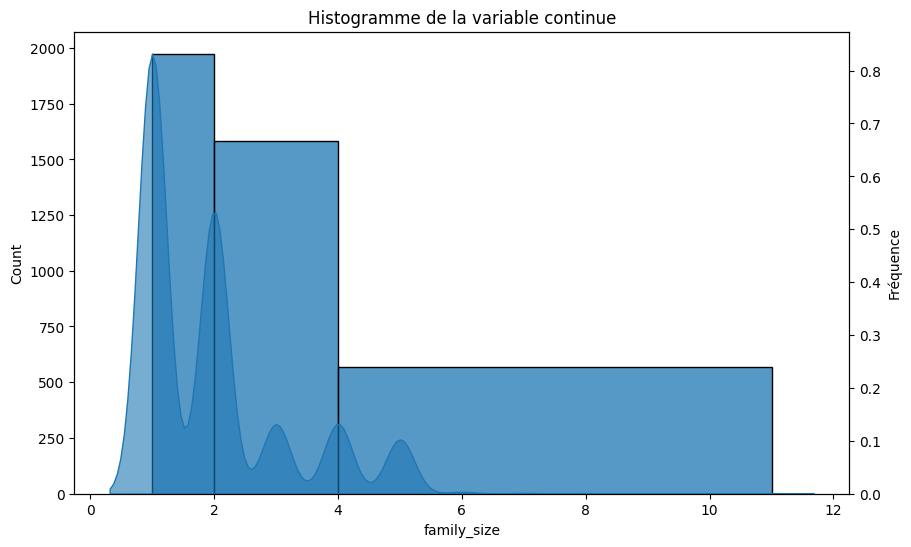

In [86]:
plot_discretized_variable(df_train, "family_size", [2,4])

In [87]:
df_train, cat_num_cols = discretization_variables(df_train, "family_size", [2,4], cat_num_cols)
df_train.head()
json_["social"]["cat"].append("family_size_bins")

[1, 2, 4, 11]


### 4.2.3 Parrainnage (SLOSLO ou referant voir la différence)

[0, 1, 2, 5, 10, 11]


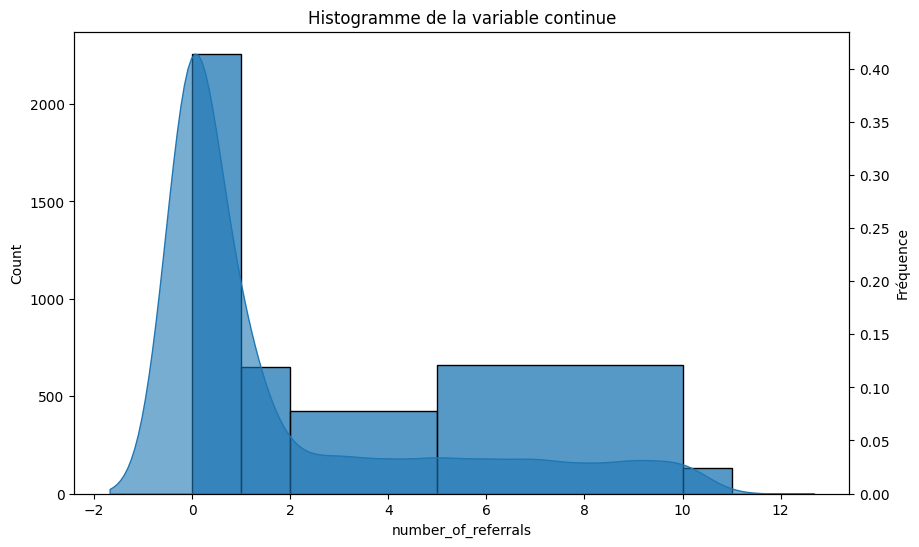

In [88]:
plot_discretized_variable(df_train, "number_of_referrals", [1,2,5,10])

In [89]:
df_train, cat_num_cols = discretization_variables(df_train, "number_of_referrals", [1,2,5,10], cat_num_cols)
df_train.head()
json_["social"]["cat"].append("number_of_referrals_bins")

[0, 1, 2, 5, 10, 11]


### 4.2.4 Durée du contrat

[1, 6, 12, 24, 60, 72]


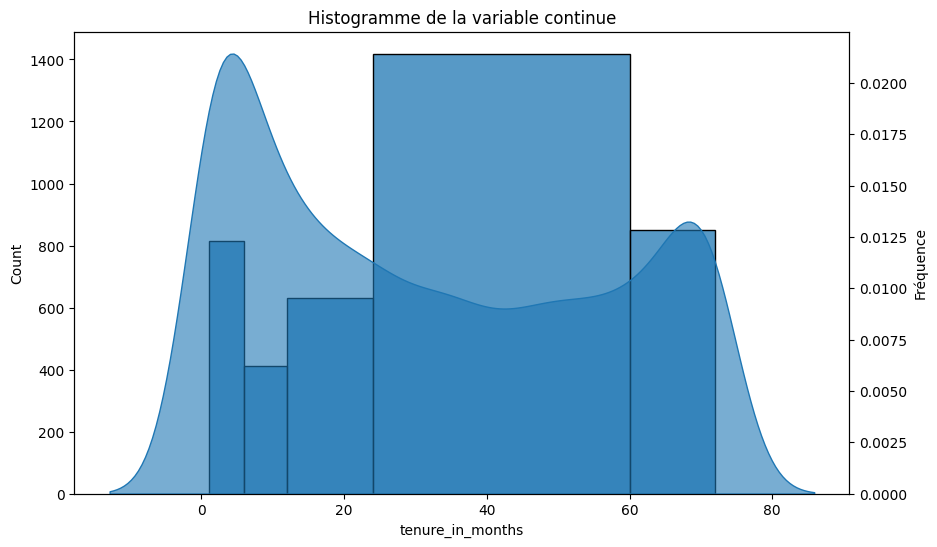

In [90]:
plot_discretized_variable(df_train, "tenure_in_months", [6,12,24,60])

In [91]:
df_train, cat_num_cols = discretization_variables(df_train, "tenure_in_months", [6,12,24,60], cat_num_cols)
df_train.head()
json_["fidélité"]["cat"].append("tenure_in_months_bins")

[1, 6, 12, 24, 60, 72]


Pas besoin de discretiser les autres variables:
'total_charges',
 'total_refunds',
 'total_extra_data_charges',
 'total_long_distance_charges' -> decoule de avg + tenue
 'total_revenue' -> decoloue de 4 autres

## 3.3 Feature engineering 

### 3.3.1 Nombre of services

In [92]:
services = json_["additional services"]["bool"]
df_train["total_of_services_add"] = (df_train[services]=="Yes").sum(axis =1)
df_train["total_of_services_add"].head()
json_["additional services"]["cat"].append("total_of_services_add")

### 3.3.2 Monthly charges

In [93]:
def has_increased_monthly_charges (df ) :
    df_ = df.copy()
    df_["ratio_monthly_charge"] = df_["monthly_charge"]/(df_["total_charges"]/df_["tenure_in_months"])
    df_["increased_monthly_charge"] = df_["ratio_monthly_charge"].apply(lambda x : 0 if x<=1 else 1)
    print(df_[["ratio_monthly_charge","increased_monthly_charge"]].head())
    return df_

In [94]:
df_train = has_increased_monthly_charges (df_train )
json_["charges"]["bool"].append("increased_monthly_charge")
json_["charges"]["num"].append("ratio_monthly_charge")

      ratio_monthly_charge  increased_monthly_charge
4706              1.016869                         1
4116              1.251456                         1
1665              0.990160                         0
99                1.022055                         1
1468              1.000000                         0


In [95]:
df_train["ratio_extra_charge"] = df_train["total_extra_data_charges"]/df_train["total_charges"]
df_train["ratio_extra_charge"].describe()
json_["charges"]["num"].append("ratio_extra_charge")

In [96]:
df_train[df_train["ratio_extra_charge"] > 0.1].head()

,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn_value,age_bins,family_size,family_size_bins,number_of_referrals_bins,tenure_in_months_bins,total_of_services_add,ratio_monthly_charge,increased_monthly_charge,ratio_extra_charge
4706,3920-HIHMQ,Female,53,No,No,No,Yes,1,No,0,26,None,Yes,16.34,Yes,Yes,DSL,19,No,No,No,No,No,No,No,No,Month-to-Month,Yes,Credit Card,49.50,1265.65,0.0,150,424.84,1840.49,0,3,2,0,0,3,3,1.016869,1,0.118516
1468,9019-QVLZD,Female,58,No,No,No,No,0,No,0,1,None,Yes,32.13,No,Yes,Fiber Optic,15,No,No,No,No,Yes,No,No,No,Month-to-Month,No,Bank Withdrawal,79.55,79.55,0.0,10,32.13,121.68,1,3,1,0,0,0,2,1.000000,0,0.125707
1788,7242-QZLXF,Male,20,Yes,No,No,Yes,3,No,0,1,None,No,0.00,No,Yes,Cable,51,No,No,No,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,25.30,25.30,0.0,10,0.00,35.30,1,0,4,1,0,0,1,1.000000,0,0.395257
3976,7465-ZZRVX,Male,63,No,No,No,No,0,No,0,1,None,Yes,14.42,No,Yes,Fiber Optic,27,No,No,No,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,70.35,70.35,0.0,10,14.42,94.77,0,3,1,0,0,0,2,1.000000,0,0.142146
1321,5016-ETTFF,Male,46,No,No,No,No,0,No,0,10,Offer D,No,0.00,No,Yes,DSL,30,No,No,Yes,No,No,No,No,No,Month-to-Month,No,Credit Card,29.50,255.25,0.0,40,0.00,295.25,1,2,1,0,0,1,2,1.155730,1,0.156709


# 4. Préselection des variables

## 4.1 Approche univariée

### 4.1.1 V de Cramer pour les variables catégorielles (SLOSLO titre à changer)

Ici on va regarder à la fois les variables entre elles et avec la variable cible

In [97]:
#@title Exécutez le code ci-dessous représentant la fonction de calcul du V de Cramer
# Charger la fonction du calcul de V de Cramer pour un dataframe
# calcul V de Cramer pour deux variables
def cramer_v_coeff(x: List, y: List) -> float:
    """Cette fonction permet de calculer le V de
    Cramer entre deux varaibles catégorielles.

    Args:
        x : Le vecteur de variable x.
        y : Le vecteur de variable y.

    Returns:
        float: La valeur V de cramer.
    """
    # Suppression des NAs
    complete_cases = x.isna()*y.isna()
    x = x[~complete_cases]
    y = y[~complete_cases]

    # Calcul du Khi-deux max (dénomimateur du V de Cramer)
    n = len(x)
    khi2_max = n * min(len(x.value_counts()), len(y.value_counts())) - 1

    # Calcul du khi-deux (numérateur du V de Cramer)
    conf_matrix = pd.crosstab(x, y)
    khi2 = ss.chi2_contingency(observed=conf_matrix, correction=True)

    # Calcul V de Cramer et récupération p_value associée
    cramer = round(np.sqrt(khi2[0] / khi2_max), 4)
    p_value = khi2[1]

    return cramer, p_value


# calcul V de Cramer pour un dataframe
def compute_cramer_v(data: pd.DataFrame) -> pd.DataFrame:
        """Calculer le V de cramer pour un dataframe.

        Args:
            data: Jeu de données sur lequel on souhaite
            calculer le V de Cramer.

        Returns:
            DataFrame contenant les différents V de Cramer.
        """
        ncols = data.shape[1]
        cols = data.columns
        cramer_matrix = np.eye(ncols)
        for j in range(ncols - 1):
            for i in range(j + 1, ncols):
                cramer_matrix[[i, j], [j, i]] = cramer_v_coeff(
                    x=data.iloc[:, j],
                    y=data.iloc[:, i]
                )[0]
        cramer_matrix = pd.DataFrame(cramer_matrix, columns=cols, index=cols)
        return cramer_matrix

In [98]:
bool_cols, cat_cols, num_cols = get_cols_by_type(json_)

Strategie : 
les nouvelles variables _bins sont à la fois catégorielles et numériques :
on les teste avec v de cramer pour voir la pertinence
on les teste avec pearsons pour voir l'amélioration avec pas bins

In [99]:
cramer_matrix = compute_cramer_v(df_train[cat_cols + bool_cols + ["churn_value"]])

[Text(0.5, 190.5815972222222, ''), Text(220.58159722222223, 0.5, '')]

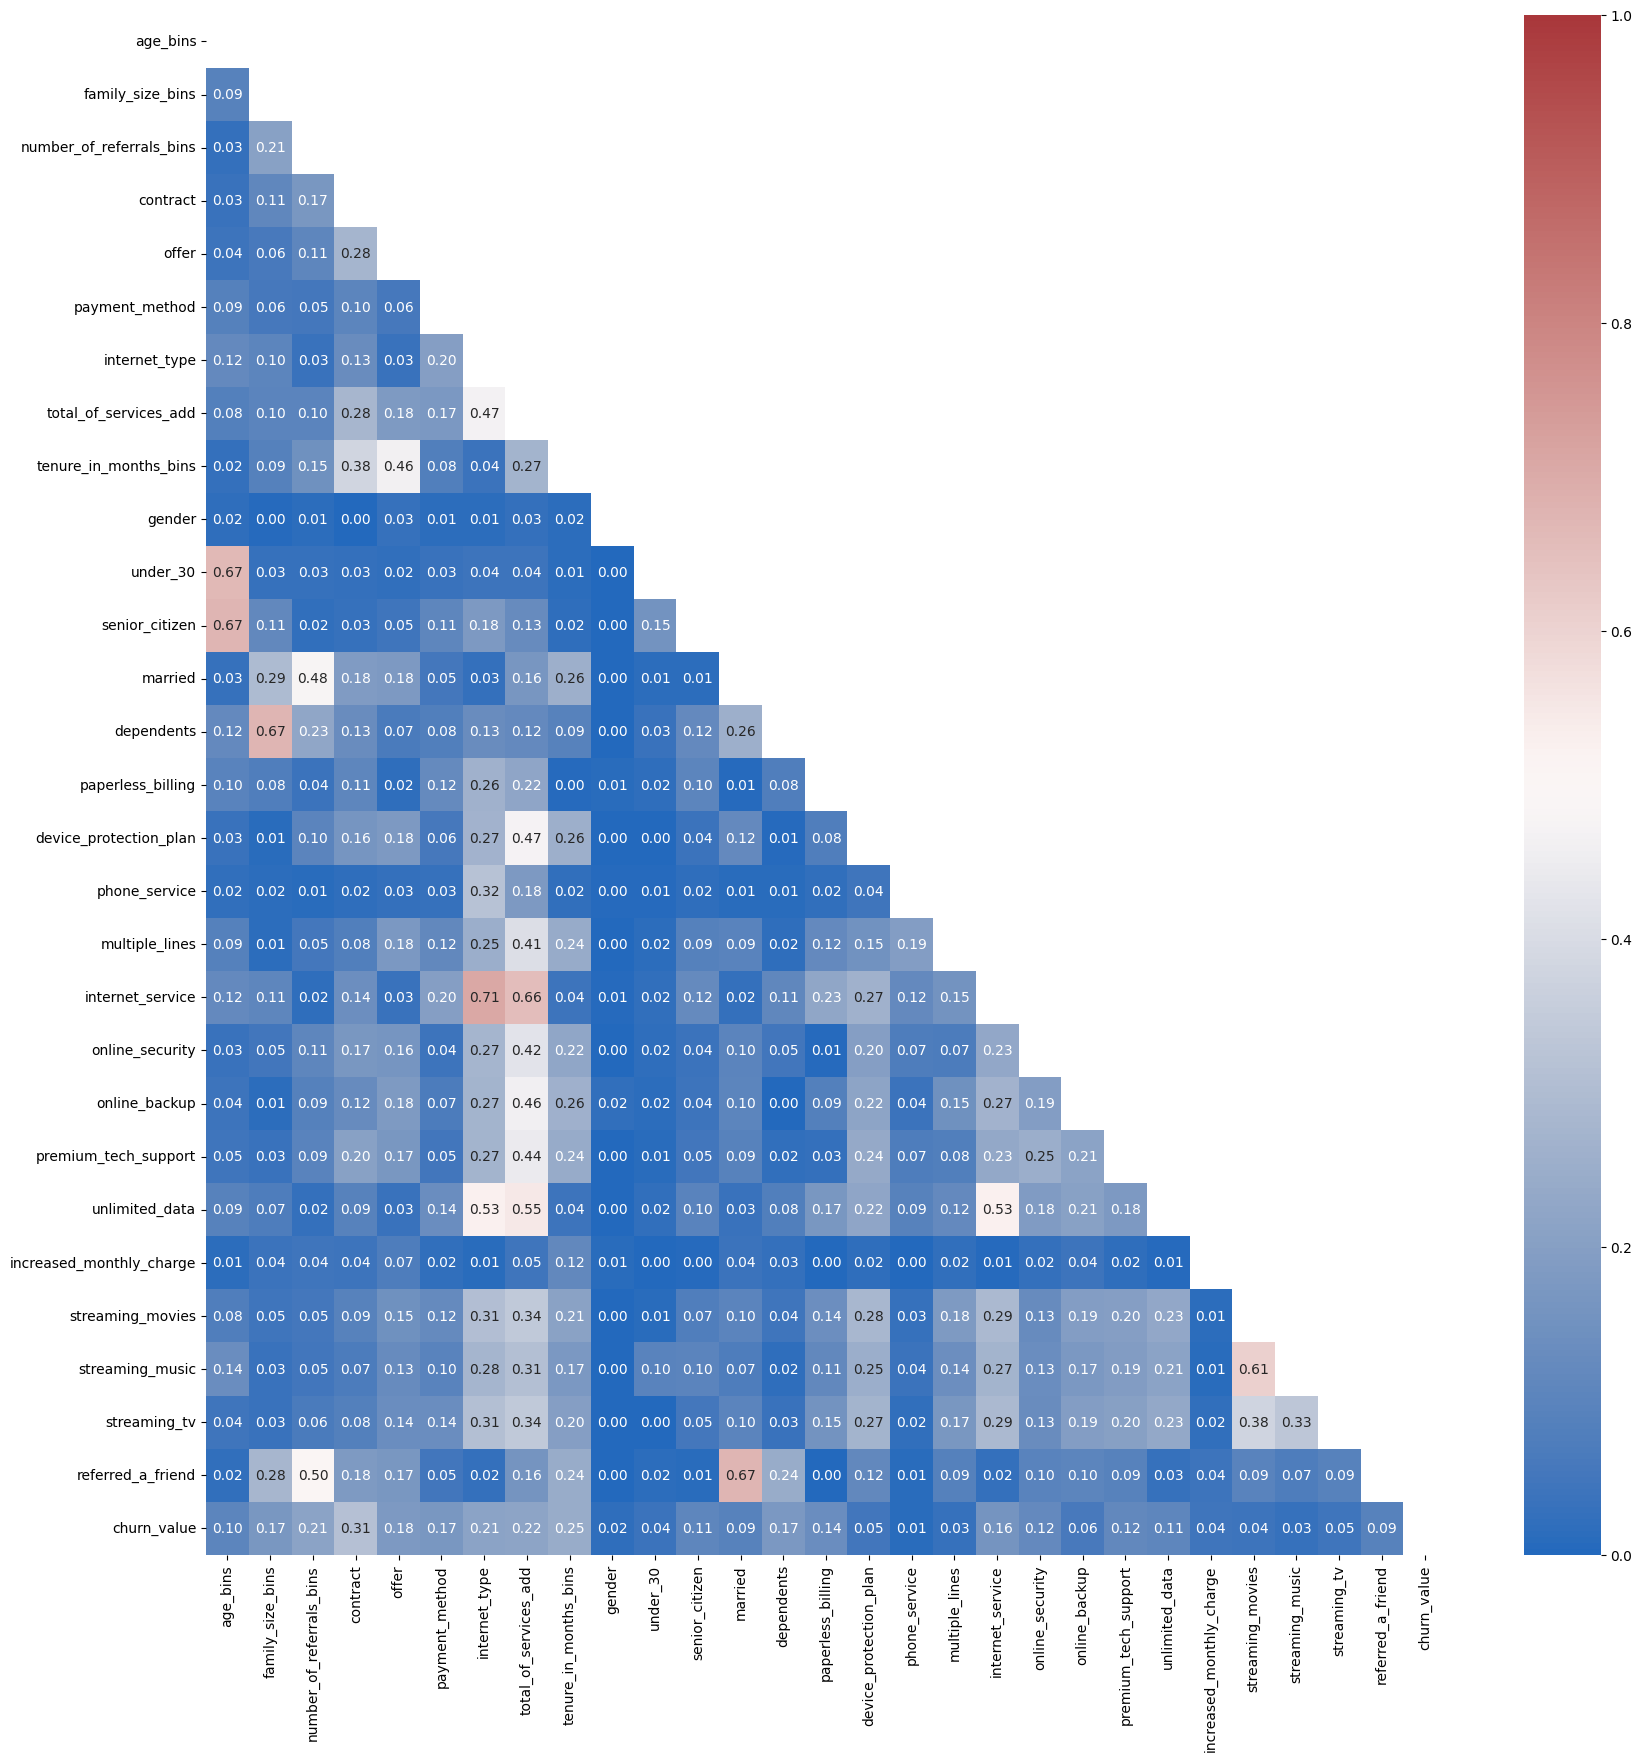

In [100]:
#Visualisation de la matrice de V de cramer_matrix
mask = np.triu(np.ones_like(cramer_matrix))

fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cramer_matrix, annot=True, fmt=".2f", mask= mask, vmax=1, vmin=0, center=0.5, cmap='vlag')
ax.set(xlabel="", ylabel="")
#ax.xaxis.tick_top()

#SLOSLO check length
#COlor = white + red

On se rend compte que les différentes liaisons entre les variables ne sont pas très fortes, elles n'excèdent pas les 0.67.

In [101]:
#cat_cols_2.remove("churn_value")
cramer_test = []
for i,var in enumerate(cat_cols + bool_cols) : 
    cramer_results  =  cramer_v_coeff(x=df_train.loc[:,var],
                    y=df_train.loc[:,"churn_value"])
    cramer_test.append(
        {
            'features' : var,
            'cramer_v' : np.round(cramer_results[0],2),
            'p-value' : np.round(cramer_results[1],2)
        })
res = pd.DataFrame(cramer_test)#, columns=["Cramer_coef","p_value"], index=var)

# res
res.sort_values(by='cramer_v', ascending=False)

,features,cramer_v,p-value
3,contract,0.31,0.00
8,tenure_in_months_bins,0.25,0.00
7,total_of_services_add,0.22,0.00
2,number_of_referrals_bins,0.21,0.00
6,internet_type,0.21,0.00
4,offer,0.18,0.00
5,payment_method,0.17,0.00
13,dependents,0.17,0.00
1,family_size_bins,0.17,0.00
18,internet_service,0.16,0.00


Discussion et analyse :
En considérant un seuil de liaison minimale de 0.1 on supprime les variables "device_protection_plan", "online_backup", "streaming_movies", "streaming_tv", "under_30", "streaming_music", "multiple_lines", "gender", "phone_service" soit 9 variables.
En considérant le critère de significativité de 0.05 on suprimer 3 variables à savoir 	"multiple_lines", "gender", "phone_service"

Regle du coude: La règle du coud n'est pas valide dans notre contexte car les v de cramer ne présentent pas claireement un seul coude mais 2. au risque de tronquer trop fortement.

Du coup, faire un commentaire comme quoi les differentes bins sont ok

In [102]:
cat_to_del = res.loc[res["cramer_v"]<0.1,"features"].tolist()


In [103]:
# créer un graphe du coude

#

In [104]:
json_ =  upd_json(json_, cat_to_del)

### 4.1.2 Corelation de Pearson pour les variables numériques (SLOSLO titre à changer)

In [105]:
cor_pearsons = df_train[num_cols + cat_num_cols + ["churn_value"]].corr()

[Text(0.5, 135.5815972222222, ''), Text(158.0815972222222, 0.5, '')]

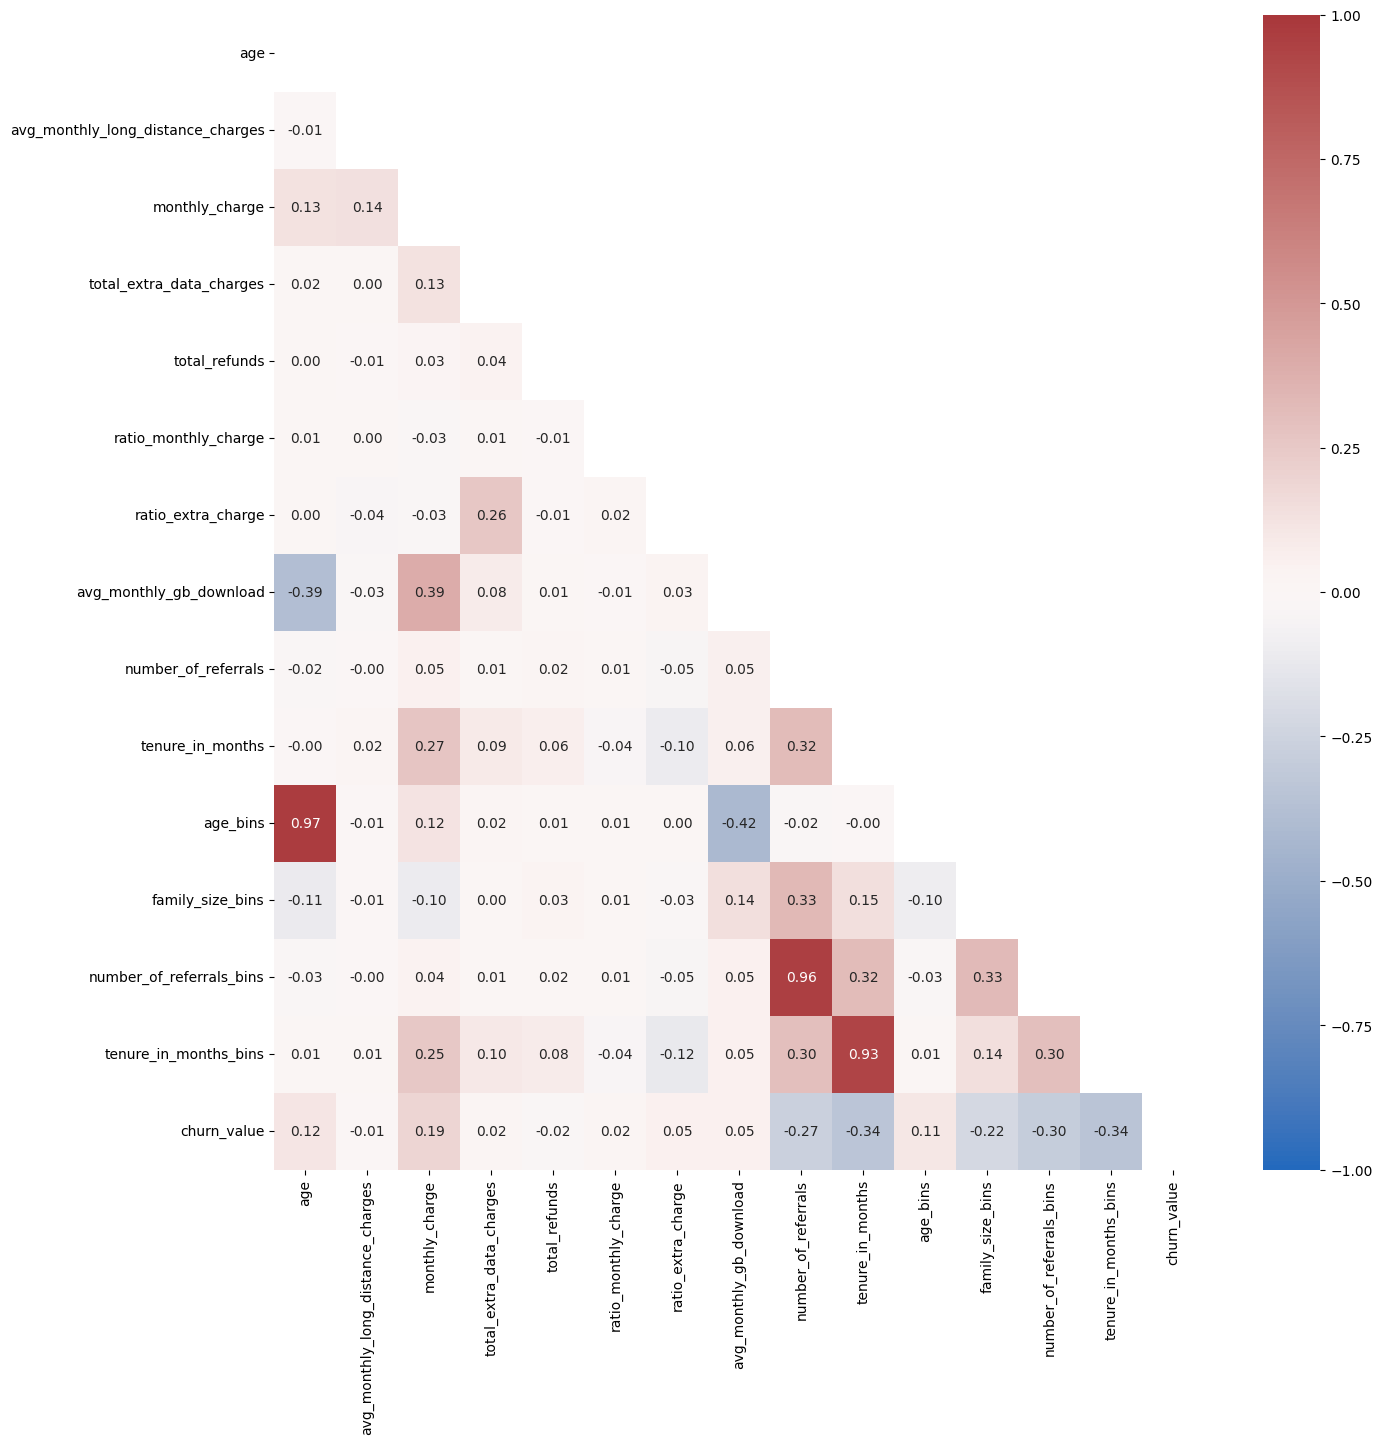

In [106]:
#Visualisation de la matrice de V de cramer_matrix
mask = np.triu(np.ones_like(cor_pearsons))

fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cor_pearsons, annot=True, fmt=".2f", mask= mask, vmax=1, vmin=-1, center=0, cmap='vlag')
ax.set(xlabel="", ylabel="")
#ax.xaxis.tick_top()

Il y a de forte corrélation entre certaines variable numériques :
* total_charge - tenure_in_month - monthly_charge
* total_long-ditance_ - tenure_in_month -  avg_mmonthly - total_charge
* total_revenue - tenure_in_month - monthly_charge - total_charge - total_long..
* total_service - monthly charges - total charges

from scratch

In [107]:
### CODEZ ICI  : Remplaçez les None ###

# Construire un dataframe contenant à la fois les coefficients
# du V de Cramer et la p-value associée à chaque variable catégorielle
pearson_matrix = []
for col in num_cols + cat_num_cols:
    # Calculez le V de pearson entre la variable col et y
    pearson_values =ss.pearsonr(x=df_train[col], y=df_train["churn_value"])
    # Concatenez dans le dictionnaire contenant la variable col,
    # la valeur du V de pearson et la p-value de significativité
    pearson_matrix.append(
        {
            'features': col,
            'coef_pearson': pearson_values[0],
            'abs_coef_pearson': abs(pearson_values[0]),
            'p_value':  round(pearson_values[1],4)
        }
    )

# Transformez la liste de dictionnaires en dataframe
# pour faciliter les manipulations à venir
pearson_matrix = (pd.DataFrame(pearson_matrix)
                 .sort_values(["coef_pearson"])
                 .reset_index(drop=True)
                )

# Affichez la matrice
pearson_matrix.sort_values(by = "abs_coef_pearson", ascending = False)

### FIN DU CODE ###

,features,coef_pearson,abs_coef_pearson,p_value
0,tenure_in_months_bins,-0.344851,0.344851,0.0000
1,tenure_in_months,-0.340871,0.340871,0.0000
2,number_of_referrals_bins,-0.296689,0.296689,0.0000
3,number_of_referrals,-0.270737,0.270737,0.0000
4,family_size_bins,-0.223609,0.223609,0.0000
13,monthly_charge,0.189912,0.189912,0.0000
12,age,0.115072,0.115072,0.0000
11,age_bins,0.107386,0.107386,0.0000
10,avg_monthly_gb_download,0.052347,0.052347,0.0008
9,ratio_extra_charge,0.048267,0.048267,0.0019



Coef de Peasons avec liaison minimale de 
avg_monthly_gb_download	et total_of_services_add


Bien expliqeur les variables retenues :


Si on s'appuie sur un p-value max de 0.05 alors :
* total-services_add , total_refunds, total_extra_data_charges, ratio_monthly_charge, avg_long* 2 disparaissent
* si on s'appuie sur une critère minimal de liaison de 0.1 alors on perd en plus raio_extra_charge, et avg_monthly_gb_download

rq:la discrétisation de tenure in month améliore la corrélation ainsi que number_of_referrals
familiy_size est mieux que n _of_dependant et sa discrétisation ne change pas grand chose
* le total_long_distance_charges a une bonne corrélation avec la target, alors que avg_monthly_long_distance_charges n'en a pas --> cela implique que cela est la valeur de tenure in month qui drive le résultat.
* la discretisation de monthly_charge et de age n'est pas terrible



In [108]:
cat_to_del = pearson_matrix.loc[pearson_matrix["abs_coef_pearson"]<0.1,"features"].tolist()
json_ =  upd_json(json_, cat_to_del)


In [109]:
cat_to_del = ["age", "number_of_referrals","tenure_in_months"]
json_ =  upd_json(json_, cat_to_del)

# A faire plus haut : 
cat_to_del = ["senior_citizen", "dependents"]
json_ =  upd_json(json_, cat_to_del)


In [110]:
bool_cols,cat_cols, num_cols = get_cols_by_type(json_)

## 4.2 Approche multivariée

In [113]:
X_train = df_train[bool_cols + cat_cols + num_cols]
y_train = df_train["churn_value"]

### 4.2.1 Preprocessing pour préselection des variables

In [114]:
# Attention dependant dégage, senior_citizen dégage
X_train_c = X_train.copy()
lb = LabelEncoder()
X_train_lb = X_train_c.apply(lb.fit_transform)
X_train_c[bool_cols] = X_train_lb[bool_cols]

# # X_train = X_train.apply(lb.fit_transform)
ord_cat = ['contract','offer', 'payment_method', 'internet_type']
X_train_dummies = pd.get_dummies(X_train_c,  prefix_sep='__',  columns=ord_cat)

rs = RobustScaler()
X_train_dummies_2 = rs.fit_transform(X_train_dummies[num_cols])
X_train_dummies[num_cols] = X_train_dummies_2


### 4.2.2 Récursive Feature Elimination

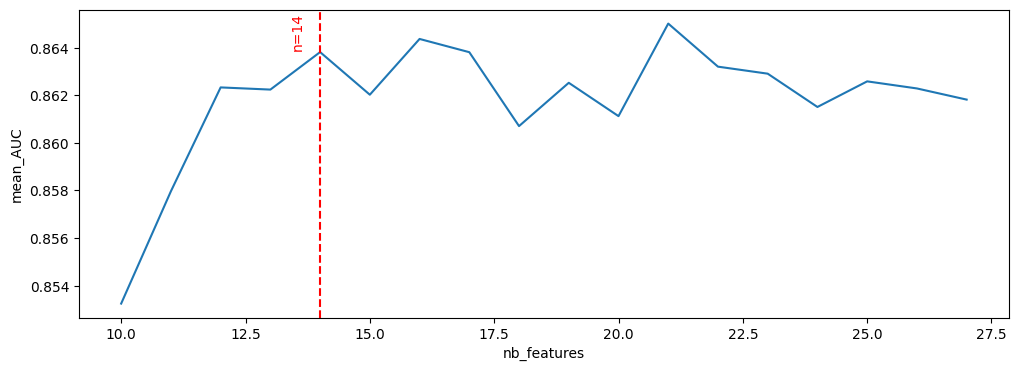

In [116]:
rfe_selector = RFECV(RandomForestClassifier(random_state=seed), 
                      step=1, min_features_to_select=10, cv=3, 
                      scoring='roc_auc', verbose=0, n_jobs=-1)

rfe_selector.fit(X_train_dummies, y_train)

df_rfecs = pd.DataFrame (data = {'nb_features' : range(10,X_train_dummies.shape[1]+1), 'mean_AUC' : rfe_selector.cv_results_["mean_test_score"]})

fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=df_rfecs, x="nb_features", y="mean_AUC")
ax.axvline(14, 0,1, ls = '--', color = "red")
ax.text( 13.7,  0.99, 'n=14', color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())


rfe_features_rdlist = X_train_dummies.loc[:,rfe_selector.support_].columns.tolist()

# ici pas besoin du graphique à voir si je le garde



In [117]:


def get_features_names (one_hot_encoder_features) : 
    features_filter = []
    for var in one_hot_encoder_features : 
        search_col = re.search(f"(.+)__", var)
        if search_col :
            features_filter.append(search_col.group(1))
        else :
            features_filter.append(var)
    return np.unique(features_filter).tolist()


rfe_features_rdlist_ = get_features_names(rfe_features_rdlist)
print(f"Les features retenues par la RFE avec une random forest sont : {len(rfe_features_rdlist_)}\n {rfe_features_rdlist_}")

Les features retenues par la RFE avec une random forest sont : 15
 ['age_bins', 'contract', 'family_size_bins', 'internet_service', 'internet_type', 'monthly_charge', 'number_of_referrals_bins', 'offer', 'online_security', 'paperless_billing', 'payment_method', 'premium_tech_support', 'tenure_in_months_bins', 'total_of_services_add', 'unlimited_data']


### 4.2.3 Boruta

In [119]:
 
boruta_selector  = BorutaPy(RandomForestClassifier(random_state = seed, max_depth = 4), n_estimators='auto',  verbose = 0)
boruta_selector.fit(X_train_dummies.values, y_train.values.ravel())
var_boruta = X_train_dummies.loc[:,boruta_selector.ranking_ <= 2].columns.tolist()
var_boruta = get_features_names(var_boruta)
    
print(f"pour max_depth = 4 \n {len(var_boruta)} Variables retenues : la liste \n :{var_boruta}")

pour max_depth = 4 
 15 Variables retenues : la liste 
 :['age_bins', 'contract', 'family_size_bins', 'internet_service', 'internet_type', 'monthly_charge', 'number_of_referrals_bins', 'offer', 'online_security', 'paperless_billing', 'payment_method', 'premium_tech_support', 'tenure_in_months_bins', 'total_of_services_add', 'unlimited_data']


Cl : Le nmbre de variables est ok .

# 5 Export des fichiers

## 5.1 Création d'un json

In [120]:
cat_ordinal_cols = []
cat_one_hot_encoder = []

for i,var in enumerate(cat_cols) : 
    if all(isinstance(var, (int, float)) for var in X_train[var]) : 
        cat_ordinal_cols.append(var)
    else :
        cat_one_hot_encoder.append(var)


# Données à exporter
json_var = {
    "bool": bool_cols,
    "cat_num": cat_ordinal_cols,
    "cat": cat_one_hot_encoder,
    "num": num_cols,
}

path_datadir = os.getcwd() + "/data"
path_ml_input = path_datadir + '/ML_input/'
if not os.path.exists(path_ml_input):
        os.mkdir(path_ml_input)

path_json_output = path_ml_input + "variable_types.json"
# Export du JSON dans le fichier
with open(path_json_output, "w") as fichier:
    json.dump(json_var, fichier, indent=4)



## 5.2 Export de df_train, df_test, df_eval

In [121]:
def feature_engineering (df, services) :
	df_=df.copy()
	df_ = discretization_variables (df_, 'age', [30,40,50,65],cat_num_cols) [0]
	df_["family_size"] = df_["number_of_dependents"] + 1 + df_["married"].map({"Yes" : 1, "No": 0})
	df_ = discretization_variables (df_, 'family_size', [2,4],cat_num_cols) [0]
	df_ = discretization_variables (df_, 'number_of_referrals', [1,2,5],cat_num_cols) [0] # erreur ici
	df_ = discretization_variables (df_, 'tenure_in_months', [6,12,24,60],cat_num_cols) [0]

	df_["total_of_services_add"] = (df_[services]=="Yes").sum(1)
	return df_


In [122]:
df_train = df_train[bool_cols + cat_cols + num_cols + ["churn_value"]]
df_train.to_csv(path_ml_input + '/df_train.csv', index=False)

df_test = feature_engineering(df_test, services)
df_test = df_test[bool_cols + cat_cols + num_cols + ["churn_value"]]
df_test.to_csv(path_ml_input + '/df_test.csv', index=False)

df_eval = feature_engineering(df_eval, services)
df_eval = df_eval[bool_cols + cat_cols + num_cols ]
df_eval.to_csv(path_ml_input + '/df_eval.csv', index=False)



[19, 30, 40, 50, 65, 80]
[1, 2, 4, 8]
[0, 1, 2, 5, 10]
[1, 6, 12, 24, 60, 72]
[19, 30, 40, 50, 65, 80]
[1, 2, 4, 10]
[0, 1, 2, 5, 11]
[1, 6, 12, 24, 60, 72]
